In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import os

Using TensorFlow backend.
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/phan.huy.hoang/venv3/lib/python3.6/sit

In [2]:

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense, Activation


In [3]:
import cv2
from sklearn.model_selection import train_test_split

In [4]:
def show_image(path):
    img = Image.open(path)
    img_arr = np.array(img)
    plt.figure(figsize=(7,7))
    plt.imshow(np.transpose(img_arr, (0, 1, 2)))

In [5]:
def show_transformed_image(image):
    np_image = image.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

In [6]:
def wfile(root):
    img_fps = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            img_fps.append(os.path.join(path, name))

    return sorted(img_fps)

In [7]:
def norm_mean_std(img):
    img = img / 255
    img = img.astype('float32')
    mean = np.mean(img, axis=(0, 1, 2))  # Per channel mean
    std = np.std(img, axis=(0, 1, 2))
    img = (img - mean) / std
    
    return img

In [46]:
class FlowerClassifyGenerator(keras.utils.Sequence):
    def __init__(self, img_fps, labels, batch_size=8,
                 img_size=(224, 224), n_channels=3,
                 no_classes=1, shuffle=True, mode='arc'):

        self.img_size = img_size
        self.batch_size = batch_size
        self.mode = mode
        
        self.img_fps = img_fps
        self.labels = labels
        assert len(self.img_fps) == len(self.labels)
        self.ids = range(len(self.img_fps))

        self.n_channels = n_channels
        self.no_classes = no_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        temp_ids = [self.ids[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(temp_ids)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_img(self, img_fp):
#         try:
        img = cv2.imread(img_fp)[:, :, ::-1]
#         except TypeError:
# #             print(img_fp)
#             return None
        return img
     
    def norm_img(self, img):
        img = img / 255
        img = img.astype(np.float32)
        return img
        
    def __data_generation(self, ids):
        # Initialization
        X = np.empty((0, *self.img_size, self.n_channels), dtype=np.float32)
        y = []

        # Generate data
        for index, id_ in enumerate(ids):
            print(id_, index)
            img_fp = self.img_fps[id_]
            img = self.load_img(img_fp)
            label = self.labels[id_]
            if img is None:
                continue
                
            # resize + padding
#             img = resize_padding(img, desired_size=self.img_size[0])
            img = cv2.resize(img, self.img_size)
            
            # normalize image
            img = norm_mean_std(img)
#             img = self.norm_img(img)
            
            img = np.expand_dims(img, axis=0)
            
            X = np.vstack((X, img))
            y.append(label)
        
#         y = keras.utils.to_categorical(y, num_classes=self.no_classes)
#         y = y.astype(np.float32)        
        return X, y

In [47]:
ROOT_DATA = "/home/phan.huy.hoang/phh_workspace/data/flower_data/flowers"
TRAIN_FD = os.path.join(ROOT_DATA, "train")
VAL_FD = os.path.join(ROOT_DATA, "valid")
TEST_FD = os.path.join(ROOT_DATA, "test")

In [48]:
check = wfile(TEST_FD)
len(check)

819

In [49]:
train_img_fps = wfile(TRAIN_FD)
val_img_fps = wfile(VAL_FD)
test_img_fps = wfile(TEST_FD)

In [50]:
flower_train_size = len(train_img_fps)
flower_test_size = len(test_img_fps)

In [51]:
flower_train_size, flower_test_size

(6552, 819)

In [52]:
blank = wfile("/home/phan.huy.hoang/Downloads/imageNet_non_flowers")

In [53]:
len(blank)

7074

In [54]:
train_blank, test_blank = train_test_split(blank, shuffle = False, test_size=0.33)

In [55]:
len(train_blank), len(test_blank)

(4739, 2335)

In [56]:
train_img_fps_clone = train_img_fps
test_img_fps_clone = test_img_fps

In [57]:
for i in range(len(train_blank)):
    train_img_fps_clone.append(train_blank[i])
    
for i in range(len(test_blank)):
    test_img_fps_clone.append(test_blank[i])

In [58]:
len(train_img_fps), len(test_img_fps)

(11291, 3154)

In [59]:
train_labels = [0] * len(train_img_fps_clone)
test_labels =[0] * len(test_img_fps_clone)

In [60]:
for i in range(flower_train_size,len(train_img_fps_clone)):
    train_labels[i]=1
for i in range(flower_test_size,len(test_img_fps_clone)):
    test_labels[i]=1

In [61]:

# import os
# root = "/home/phan.huy.hoang/Downloads/image_non_flowers"
# for file in os.listdir(root):

#     src = os.path.join(root, file)
#     dst = os.path.join(root, file + '.jpg')
#     print(file)
#     if not os.path.exists(dst): # check if the file doesn't exist
#         os.rename(src, dst)

## Data Generator

In [62]:
train_gen = FlowerClassifyGenerator(train_img_fps, train_labels)
test_gen = FlowerClassifyGenerator(test_img_fps, test_labels)

In [63]:
train_gen[0][0]

10663 0
4274 1
2666 2
8115 3
3095 4
10614 5
1776 6
3621 7


array([[[[-8.26050997e-01, -8.26050997e-01, -8.26050997e-01],
         [-8.26050997e-01, -8.26050997e-01, -8.26050997e-01],
         [-8.26050997e-01, -8.26050997e-01, -8.26050997e-01],
         ...,
         [-7.05149412e-01, -7.05149412e-01, -7.05149412e-01],
         [-7.39692748e-01, -7.39692748e-01, -7.39692748e-01],
         [-7.39692748e-01, -7.39692748e-01, -7.39692748e-01]],

        [[-8.26050997e-01, -8.26050997e-01, -8.26050997e-01],
         [-8.26050997e-01, -8.26050997e-01, -8.26050997e-01],
         [-8.26050997e-01, -8.26050997e-01, -8.26050997e-01],
         ...,
         [-7.22421050e-01, -7.22421050e-01, -7.22421050e-01],
         [-6.87877774e-01, -6.87877774e-01, -6.87877774e-01],
         [-7.05149412e-01, -7.05149412e-01, -7.05149412e-01]],

        [[-8.26050997e-01, -8.26050997e-01, -8.26050997e-01],
         [-8.26050997e-01, -8.26050997e-01, -8.26050997e-01],
         [-8.26050997e-01, -8.26050997e-01, -8.26050997e-01],
         ...,
         [-7.56964386e-0

In [24]:
batch_size = 8
num_classes = 1
epochs = 10

In [38]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau

img_width, img_height = 224, 224
batch_size = 8
samples_per_epoch = 1000
validation_steps = 300
nb_filters1 = 32
nb_filters2 = 64
nb_filters3 = 128
nb_filters4 = 256
conv1_size = 3
conv2_size = 2
pool_size = 2
classes_num = 1
lr = 0.0004

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)


# model = Sequential()
# model.add(Convolution2D(nb_filters1, conv1_size, conv1_size, border_mode ="same", input_shape=(img_width, img_height, 3)))
# model.add(Convolution2D(nb_filters1, conv1_size, conv1_size, border_mode ="same"))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

# model.add(Convolution2D(nb_filters2, conv2_size, conv2_size, border_mode ="same"))
# model.add(Convolution2D(nb_filters2, conv2_size, conv2_size, border_mode ="same"))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(pool_size, pool_size), dim_ordering='th'))

# model.add(Convolution2D(nb_filters3, conv2_size, conv2_size, border_mode ="same"))
# model.add(Convolution2D(nb_filters3, conv2_size, conv2_size, border_mode ="same"))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(pool_size, pool_size), dim_ordering='th'))

# model.add(Convolution2D(nb_filters4, conv2_size, conv2_size, border_mode ="same"))
# model.add(Convolution2D(nb_filters4, conv2_size, conv2_size, border_mode ="same"))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(pool_size, pool_size), dim_ordering='th'))


# model.add(Flatten())
# model.add(Dense(256))
# model.add(Activation("relu"))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer=optimizers.RMSprop(lr=lr),
#               metrics=['accuracy'])

/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(224, 224,..., padding="same")`
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2), padding="same")`
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2), padding="same")`
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/i

In [41]:
input_shape=(224,224,3)

In [61]:
# model = Sequential()

# model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_shape, activation='relu'))
# model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
# model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
# model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
# model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(512, 3, 3, border_mode='same', activation='relu'))
# model.add(Conv2D(512, 3, 3, border_mode='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy',
#             optimizer=optimizers.RMSprop(lr=0.0001),
#             metrics=['accuracy'])

/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(224, 224,..., activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  after removing the cwd from sys.path.
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  import sys
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/

In [67]:
model = Sequential()

model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 2, 2, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 2, 2, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=0.0001),
            metrics=['accuracy'])

/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(224, 224,..., activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  if __name__ == '__main__':
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2), activation="relu", padding="same")`
  if sys.path[0] == '':
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages

In [27]:
# test_fp = "/home/phan.huy.hoang/Downloads/image_non_flowers/2711.jpg"

In [28]:
# img = cv2.imread(test_fp)
# print(img)

In [68]:
model.fit_generator(
    train_gen,
    samples_per_epoch=len(train_gen),
    epochs=epochs,
    validation_data=test_gen,
    callbacks=[reduce_lr]
)

/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., epochs=10, validation_data=<__main__...., callbacks=[<keras.ca..., steps_per_epoch=179)`
  


Epoch 1/10
179/179 [==============================] - 21s 115ms/step - loss: 0.5548 - accuracy: 0.7172 - val_loss: 0.7602 - val_accuracy: 0.7324
Epoch 2/10
179/179 [==============================] - 20s 113ms/step - loss: 0.3889 - accuracy: 0.8394 - val_loss: 0.3073 - val_accuracy: 0.8932
Epoch 3/10
179/179 [==============================] - 20s 114ms/step - loss: 0.3294 - accuracy: 0.8652 - val_loss: 0.4609 - val_accuracy: 0.9120
Epoch 4/10
179/179 [==============================] - 20s 111ms/step - loss: 0.2853 - accuracy: 0.8932 - val_loss: 1.4263 - val_accuracy: 0.9204
Epoch 5/10
179/179 [==============================] - 20s 111ms/step - loss: 0.2791 - accuracy: 0.8980 - val_loss: 0.0420 - val_accuracy: 0.9182
Epoch 6/10
179/179 [==============================] - 20s 112ms/step - loss: 0.2568 - accuracy: 0.9085 - val_loss: 0.1623 - val_accuracy: 0.9287
Epoch 7/10
179/179 [==============================] - 20s 112ms/step - loss: 0.2349 - accuracy: 0.9183 - val_loss: 0.0171 - val_ac

In [69]:
hist = model.history.history

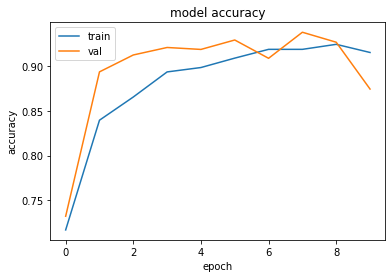

In [70]:
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

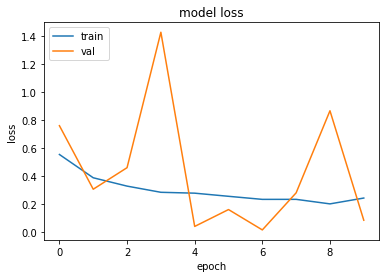

In [71]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [227]:
128**2+128

16512

In [73]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 28, 28, 64)      

In [48]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 56, 56, 128)      

In [74]:
model.save_weights('./models/classifier.h5')

## Validation

In [5]:
pred_model = Sequential()

pred_model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=(224,224,3), activation='relu'))
pred_model.add(MaxPooling2D(pool_size=(2, 2)))

pred_model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
pred_model.add(MaxPooling2D(pool_size=(2, 2)))

pred_model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
pred_model.add(MaxPooling2D(pool_size=(2, 2)))

pred_model.add(Conv2D(64, 2, 2, border_mode='same', activation='relu'))
pred_model.add(MaxPooling2D(pool_size=(2, 2)))

pred_model.add(Conv2D(128, 2, 2, border_mode='same', activation='relu'))
pred_model.add(MaxPooling2D(pool_size=(2, 2)))

pred_model.add(Flatten())
pred_model.add(Dense(128, activation='relu'))
pred_model.add(Dropout(0.5))

pred_model.add(Dense(128, activation='relu'))
pred_model.add(Dropout(0.5))

pred_model.add(Dense(1))
pred_model.add(Activation('sigmoid'))


/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(224, 224,..., activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  if __name__ == '__main__':
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2), activation="relu", padding="same")`
  if sys.path[0] == '':
/home/phan.huy.hoang/venv3/lib/python3.6/site-packages

In [6]:
pred_model.load_weights('./models/classifier.h5')

In [7]:
def img_process(img_fp):
    img_resize = cv2.resize(img_fp,(224,224))
    img_norm = norm_mean_std(img_resize)
    img_inp = np.expand_dims(img_norm, axis=0)
    return img_inp

In [51]:
img_test=""

In [8]:
rat=cv2.imread("/home/phan.huy.hoang/Downloads/image_non_flowers/2769.jpg")

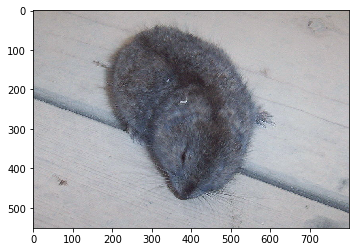

In [9]:
plt.imshow(rat)

In [14]:
img_out1=img_process(rat)
label1 = pred_model.predict(img_out1)

In [15]:
label1

array([[0.98047525]], dtype=float32)

In [16]:
import random

In [17]:
test_classification="/home/phan.huy.hoang/phh_workspace/flower_retrieval/flower_segmentation/input/valid_flower"

In [18]:
test_images = wfile(test_classification)

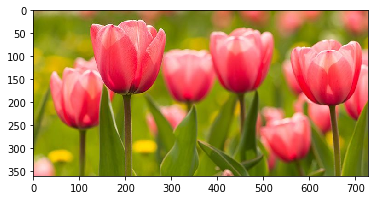

In [93]:
img_check = cv2.imread("/home/phan.huy.hoang/phh_workspace/flower_retrieval/flower_segmentation/input/valid_flower/tulip1.jpg")[:,:,::-1]

plt.imshow(img_check)

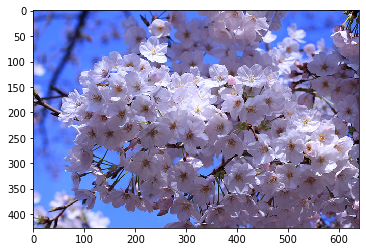

In [61]:
random_img = random.choice(test_images)
img_valid = cv2.imread(random_img)[:,:,::-1]
plt.imshow(img_valid)

In [62]:
img_out1=img_process(img_valid)
label = pred_model.predict(img_out1)
label

array([[0.57150877]], dtype=float32)

In [168]:
threshold_num = 0.45

In [42]:
if (label[0][0]<threshold_num): result = 0
else: result = 1

NameError: name 'label' is not defined

In [169]:
from sklearn.metrics import accuracy_score

In [170]:
threshold = np.arange(0.05, 1, 0.05)

In [171]:
threshold

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [175]:
accuracy = []
for threshold_num in threshold:
    y_pred = []
    for image in test_img_fps_clone:
        try:
            img = cv2.imread(image)[:, :, ::-1]
        except TypeError:
            continue
        img_inp = img_process(img)
        label = pred_model.predict(img_inp)
        if (label[0][0]<threshold_num): y_pred.append(0)
        else: y_pred.append(1)
    accuracy.append(accuracy_score(test_labels, y_pred))

In [178]:
accuracy

[0.9432799013563502,
 0.9414303329223181,
 0.936806411837238,
 0.9284833538840938,
 0.9173859432799013,
 0.9099876695437731,
 0.9022811344019729,
 0.8933415536374846,
 0.8825524044389642,
 0.87422934648582,
 0.8640567200986436,
 0.8526510480887793,
 0.8397040690505548,
 0.8276818742293465,
 0.80980271270037,
 0.7894574599260172,
 0.752157829839704,
 0.6803329223181258,
 0.5514796547472256]

In [177]:
accuracy.index(max(accuracy))

0

In [63]:
import tensorflow as tf

In [64]:
tf.keras.backend.set_learning_phase(0)  # Ignore dropout at inference
export_path = './temp_models/serving/1'

In [65]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import utils
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def
from tensorflow.contrib.session_bundle import exporter

builder = saved_model_builder.SavedModelBuilder(export_path)

signature = predict_signature_def(
    inputs={
        'input_image': pred_model.input,
    },
    outputs={
        'y_pred': pred_model.output
    }
)

with K.get_session() as sess:
    builder.add_meta_graph_and_variables(
        sess=sess,
        tags=[tag_constants.SERVING],
        signature_def_map={'classifier': signature},
        # or
        # signature_def_map={signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature},
    )
    builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./temp_models/serving/1/saved_model.pb
